# **Association Rules Analysis**

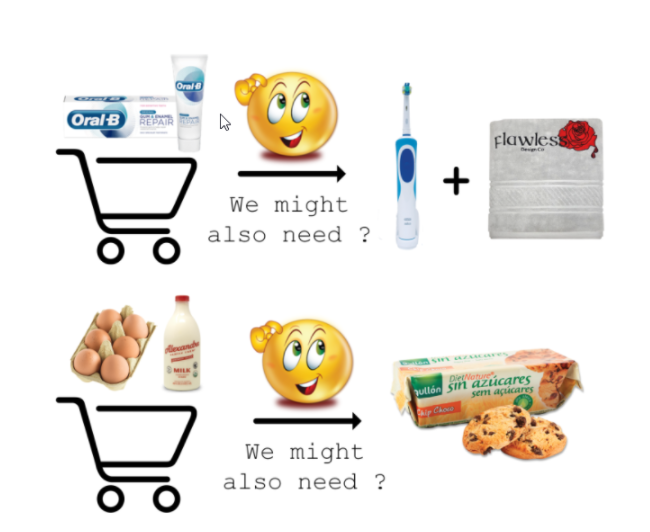

Association Rules are one of the first techniques used in data mining and it is one of the first analyzes that comes to mind when data mining is mentioned. Association analysis; It is the analysis made to reveal the connection between the data we have. One of the first examples that comes to mind when it comes to association analysis is diapers and beer!

# **DIAPER - BEER RELATIONSHIP**

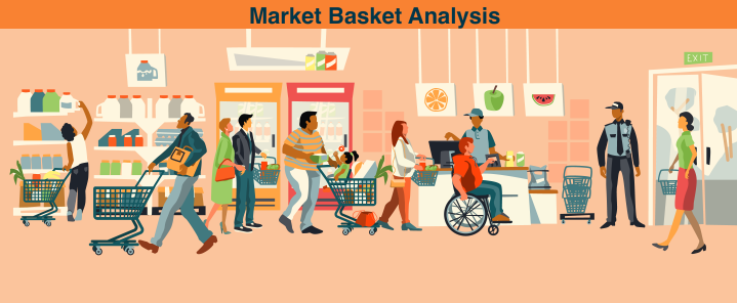 

When we consider diapers and beer one by one, you may think that they are two unrelated products, but if we look at the analyzes made by the American retail giant Walmart, we can see that they are not so irrelevant. According to the analysis, 4,000 of the 200,000 purchase data handled include diapers. 5,500 of them contain beer. In addition, 3,500 transactions include both diapers and beer products. When this review is interpreted, it is observed that parents who have new children spend their evenings at home instead of going out to have fun, buying beer. Based on these observations, Walmart manages to make a profit by putting diapers and beer in close aisles.

# **APRIORY ALGORITHM**

The Apriori algorithm is a widely used algorithm for association analysis. This algorithm has certain metrics. 

* **Support**: Indicates the rate at which a relationship is repeated across all purchases.

* **Confidence**: Indicates the probability that customers who buy product X will buy product Y.

* **Lift**: If the first product is purchased, the probability of purchasing the second product increases.

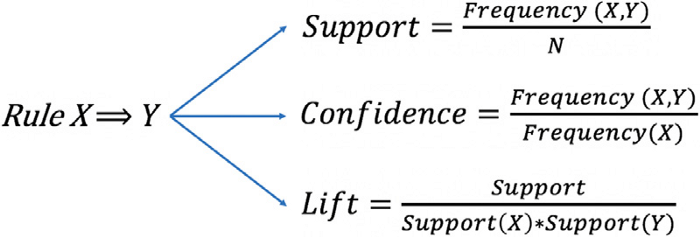

# **Business Problem**
> *Suggesting products to users at the basket stage.*

# **Acknowledgements:**
This dataset has been referred from UCI ML Repository:
https://archive.ics.uci.edu/ml/datasets/online+retail

# **Dataset Story**
> *The dataset named Online Retail II shows the sales of a UK-based online store between 01/12/2009 - 09/12/2011.
contains.
The product catalog of this company includes souvenirs. promotion
can be considered as products. There is also information that most of its customers are wholesalers.*

# VARIABLES
> * **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
> * **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
> * **Description**: Product (item) name. Nominal.
> * **Quantity**: The quantities of each product (item) per transaction. Numeric.
> * **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
> * **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
> * **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
> * **Country**: Country name. Nominal, the name of the country where each customer resides.

***The cart information of 3 different users is given below. Make the most appropriate product recommendation for this basket information.
Note: Product recommendations can be 1 or more than 1. Derive the decision rules from the 2010-2011 Germany customers.***

> ▪ **User 1 product id: 21987**

> ▪ **User 2 product id: 23235**

> ▪ **User 3 product id: 22747**

# **Data Preprocessing**

In [1]:
#!pip install mlxtend
!pip install openpyxl
#!pip install texthero

     |████████████████████████████████| 242 kB 286 kB/s eta 0:00:01


In [2]:
!pip install texthero
# Basic libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

from mlxtend.frequent_patterns import apriori, association_rules
import datetime as dt
from scipy import stats
import json

# NLP libraries
import nltk
nltk.download('omw-1.4')
import texthero as hero
from nltk.tokenize import ToktokTokenizer

# Data visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns



# Sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance

# Recommendation Libraries
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

     |████████████████████████████████| 24.2 MB 439 kB/s  eta 0:00:01
     |████████████████████████████████| 1.5 MB 44.9 MB/s eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scattertext 0.1.4 requires gensim>=4.0.0, but you have gensim 3.8.3 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.6.7 which is incompatible.


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [3]:
# We use these functions to ignore outliers.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [4]:
# We use these functions for data preprocessing
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    return dataframe

In [5]:
# The function we will use to bring the dataframe to the ARL form

def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['Invoice', "StockCode"])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [6]:
# This function is used to find the name of the product whose StockCode is given.
def check_id(dataframe, stock_code):
    if type(stock_code)==list:
        return([dataframe[dataframe["StockCode"] == code][["Description"]].values[0].tolist() for code in stock_code])
    else:
        product_name = dataframe[dataframe["StockCode"] == stock_code][["Description"]].values[0][0]
        return(product_name)

In [7]:
# This function is used to learn the rules for arl_recommender
def create_rules(dataframe, id=True, country="France"):
    dataframe = dataframe[dataframe['Country'] == country]
    dataframe = create_invoice_product_df(dataframe, id)
    frequent_itemsets = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.01)
    return rules

In [8]:
# this function is used to recommend for the product the basket
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("lift", ascending=False)
    recommendation_list = []
    for i, product in sorted_rules["antecedents"].items():
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]["consequents"]))
    recommendation_list = list({item for item_list in recommendation_list for item in item_list})
    return recommendation_list[:rec_count]

In [9]:
#!pip install openpyxl
# Let's import the data we will use.
df_= pd.read_csv('../input/d/mashlyn/online-retail-ii-uci/online_retail_II.csv')
df= df_[df_["InvoiceDate"] >= '2010-12-01']

#df = pd.read_excel (r'../input/online-retail-ii-uci/online_retail_II.xlsx')
#df= df[df["InvoiceDate"] >= '2010-12-01']

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
502938,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
502939,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
502940,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
502941,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
502942,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Cleaning Data 🧹 
1.1 Missing data 👻 
After an exploratory analysis of the dataset, it appears that 22% of the customer ids are missing which is very problematic since I want to do a Customer Segmentation later. I've tried looking at the invoice number or date without success. It's a shame that we have to lose 22% of the data but we don't have a choice.


In [10]:
df.shape

(564433, 8)

In [11]:
df = df.dropna(subset=["Customer ID"])
print('Duplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate entries: 20028


In [12]:
df.shape

(401605, 8)

Since duplicates values aren't following one another in the dataset, I could think that the customer added the same product in his basket several times without updating the quantity. The choice is here also hard to make. But, by trying this experiment on a few websites, it seems that the quantity is always updated when you add the same product. So I'll consider them as duplicates even though this data is from 2010.

## Stockcodes management

In this dataset, there are several specific transactions which aren't products. For example, we can have a line with 'Discount' as a description. This probably means that the customer had a discount during his purchase. Before deleting lines that aren't product, I'll create 2 features : discount and postage in which I'll store different discounts and postage customers had.


In [13]:
df['Discount'] = 0
for index, col in  df[df['StockCode']=='D'].iterrows():
    invoice = col['Invoice']
    price = col['Price']
    
    df.loc[(df.Invoice == invoice), 'Discount'] = price

In [14]:
df['Postage'] = 0
for index, col in  df[df['StockCode']=='POST'].iterrows():
    invoice = col['Invoice']
    price = col['Price']
    
    df.loc[(df.Invoice == invoice), 'Postage'] = price

In [15]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes 

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [16]:
for code in list_special_codes : 
    df = df[df['StockCode']!= code]

## Canceled Orders management

This part was inspired by Fabien Daniel's brilliant work in his Notebook on customer segmentation.

In [ ]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['Customer ID'] == col['Customer ID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

In [ ]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

# Product Tagging

## Cleaning the description

I'll take this opportunity to try a new nlp library I recently discovered : TextHero in order to clean my data. It is pretty convenient since with one line of code I can do several processing functions like lower_case, removing strop words, lemmatization, ...


In [ ]:
product_df = df_cleaned
product_df['Description'] = df['Description'].pipe(hero.clean)

In [ ]:
product_df = df_cleaned.drop(columns=['StockCode', 'Invoice', 'Customer ID', 'Price', 'Quantity', 'InvoiceDate', 'Country'])
product_df['Description'] = df['Description'].pipe(hero.clean)

In [ ]:
tw = hero.visualization.top_words(product_df['Description']).head(40)

fig = px.bar(tw)
fig.show()

From this graph, I decided to make 3 different features out of the product description : color, category and design. I'll group several thing in design since it would like product caracteristics. For example, "Retrospot", "Vintage", "Feltcraft", ... And in categories we'll have something like "Cake", "Christmas", "Bottle", ... I also took a look at bi-grams even though I didn't put it in this notebook.

# Product's category
## Semi manually tagging products

## Product's color 

In [ ]:
from nltk.tokenize import ToktokTokenizer
token = ToktokTokenizer()

In [ ]:
def TagExtractor(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if  w in tags]
    
    return ' '.join(map(str, filtered))

In [ ]:
def TagRemove(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in tags]
    
    return ' '.join(map(str, filtered))

In [ ]:
colors = ['black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'white', 'yellow', 'ivory']

In [ ]:
product_df['ProductColor'] = product_df['Description'].apply(lambda x: TagExtractor(x, colors)) 

In [ ]:
 product_df['Description'] = product_df['Description'].apply(lambda x: TagRemove(x, colors)) 

In [ ]:
tw = hero.visualization.top_words(product_df['ProductColor']).head(20)

fig = px.bar(tw)
fig.show()

In [ ]:
Categories = ['bag', 'box', 'cake', 'christmas', 'hanging', 'light', 'holder', 'sign', 'jumbo', 'lunch', 'paper', 'tea', 'card',
              'cases', 'decoration', 'water', 'bottle', 'mug', 'party', 'garden', 'wrap', 'bowl', 'birthday', 
              'photo', 'frame', 'candle', 'key', 'ring', 'travel', 'egg', 'cup', 
              'lights', 'cutlery', 'candles', 'door', 'gift', 'clock', 'trinket', 
              'drawer', 'stand', 'pencils', 'ribbons', 'napkins', 'notebook', 'photo', 'alarm', 'dog',
             'kitchen', 'storage', 'childrens', 'cup', 'cat', 'wall', 'art', 'cushion', 'cover', 'popcorn', 'soap', 'baking', 'door']

## Product Categories

In [ ]:
product_df['Categories'] = product_df['Description'].apply(lambda x: TagExtractor(x, Categories))

In [ ]:
pd.DataFrame(product_df['Categories'].value_counts()).to_excel('product_categories.xlsx')

From here, I took it on excel. I renamed and grouped categories into labels in order to have something more reliable for the classifiers later on.

In [ ]:
product_tags = pd.read_excel('./product_categories.xlsx')

In [ ]:
product_tags.head()

In [ ]:
product_df = product_df.reset_index().merge(product_tags, on='Categories', how='left').set_index('index')

In [ ]:
product_df.loc[(product_df.Description =='wicker'), 'Labels'] = 'Wicker'

product_df.loc[(product_df.Description =='assorted colour ornament'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='tissues'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='chalkboard'), 'Labels'] = 'Stationary'

product_df.loc[(product_df.Description =='milk jug'), 'Labels'] = 'Tableware'

product_df.loc[(product_df.Description =='measuring spoons'), 'Labels'] = 'Baking'

product_df.loc[(product_df.Description =='snap cards'), 'Labels'] = 'Cards'

In [ ]:
product_df.loc[(product_df.Description =='regency cakestand tier'), 'Labels'] = 'Cake Decoration'

product_df.loc[(product_df.Description =='heart wicker small'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='heart wicker large'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='edwardian parasol'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='regency teacup saucer'), 'Labels'] = 'Tea'

product_df.loc[(product_df.Description =='natural slate heart chalkboard'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='french metal door sign'), 'Labels'] = 'Door Sign'

product_df.loc[(product_df.Description =='love building block word'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='vintage snap cards'), 'Labels'] = 'Cards'

product_df.loc[(product_df.Description =='scottie dog hot water bottle'), 'Labels'] = 'Water Bottle'

product_df.loc[(product_df.Labels =='Holders'), 'Labels'] = 'Holding Decoration'

In [ ]:
for label in ['Decorative Storage', 'Hanging Decoration', 'Lights', 'Candles', 'Door Signs', 'Wall Signs', 'Wicker', 'Clocks',
             'Storage', 'Frame', 'Photo Frame', 'Wall Art', 'Holding Decoration', 'Popcorn Holder']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Home Decoration'

In [ ]:
for label in ['Lunch Bags', 'Jumbo Bags', 'Jumbo Shopper']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Bags'

In [ ]:
for label in ['Cards', 'Paper', 'Cushions', 'Wraps', 'Gift Wraps']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Gifts'

In [ ]:
for label in ['Water Bottle', 'Essentials', 'Travel', 'Pets', 'Jewelry']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Other'

In [ ]:
for label in ['Cake Decoration', 'Birthday']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Party'

In [ ]:
for label in ['Tea', 'Baking', 'Kitchen', 'Soap']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Tableware'

In [ ]:
product_df

I decided that I had too many categories and wanted to squeeze them into 10 new labels.

In [ ]:
product_df['Labels'].value_counts().sum() /product_df['Labels'].shape[0]*100

One last finishing touch and we're done. With this semi-manual work almost 60% of the data is tagged which should give us enough data for the next step

In [ ]:
product_df

In [ ]:
# The Unnamed column has been deleted.
df.columns.str.match("Unnamed")
df=df.loc[:,~df.columns.str.match("Unnamed")]
df.head()


In [ ]:
df.describe().T
# As can be seen in the description of the data, the standard deviations are very high.
# When you look at the max and min values, contradictory observations are seen. 
# At the same time, there are negative observations that should not be present in our data. 
# These cause our results to be inaccurate.

In [ ]:
# so we need to clear our data from these values.
df= retail_data_prep(df)

In [ ]:
df.describe().T

# EDA

In [ ]:
# checking the different values for country in the dataset

plt.rcParams['figure.figsize'] = (12, 10)
a = df['Country'].value_counts().tail(20)
sns.barplot(x = a.values, y = a.index, palette = 'inferno')
plt.title('Bottom 20 Countries having Online Retail Market', fontsize = 20)
plt.xlabel('Names of Countries')
plt.ylabel('Count')
plt.show()

In [ ]:
# checking how many quantity of products have been sold online from each country

a = df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = False)[1:]
print(a)

sns.barplot(x = a.values, y = a.index, palette = 'magma')
plt.title('Quality of Products sold in all the countries except UK')
plt.show()

In [ ]:
# Having a look at the bottom 20 Countries in terms of Quantities according to the countries

color = plt.cm.viridis(np.linspace(0, 1, 20))
df['Quantity'].groupby(df['Country']).agg('sum').sort_values(ascending = True).head(20).plot.bar(figsize = (15, 7),
                                                                                                    color = color)

plt.title('Bottom 20 Countries according to Quantity Sold Online', fontsize = 20)
plt.xlabel('Names of the Countries')
plt.ylabel('Number of Items Sold')
plt.show()

## FEATURE ENGINEERING 
## ADDING A COLUMN TO THE DATASET

### sales = unitprice*quantity

In [ ]:


df['Sales'] = df['Price'] * df['Quantity']

# visualizing the sales in the entire globe
plt.rcParams['figure.figsize'] = (15, 5)
sns.histplot(df['Sales'], color = 'crimson')
plt.title('Distribution of Sales in entire globe', fontsize = 20)
plt.xlabel('Sales in different Countries')
plt.ylabel('Sales')
plt.show()

In [ ]:
# looking at each country's sales

plt.rcParams['figure.figsize'] = (9, 12)
a = df['Sales'].groupby(df['Country']).agg('sum').sort_values(ascending = False)[1:]
print(a)
sns.barplot(x = a.values, y = a.index, palette = 'inferno')
plt.title('Sales of all the Countries Except UK')
plt.show()

In [ ]:
# looking at the bottom 20 countries sales wise

df['Sales'].groupby(df['Country']).agg('sum').sort_values(ascending = True).head(20).plot.bar(figsize = (15, 7), color = 'pink')
plt.title('Bottom 20 Countries Sales wise', fontsize = 20)
plt.xlabel('Names of Countries')
plt.ylabel('Sales')
plt.show()

In [ ]:
# let's look at Sales vs Invoicedate (Time series Analysis)

plt.rcParams['figure.figsize'] = (15, 5)
df.plot(x = 'InvoiceDate', y = 'Sales')
plt.title("Time Series Analysis of Sales", fontsize = 20)
plt.xlabel('Date of Purchase')
plt.ylabel('Sales')
plt.show()

In [ ]:
# checking how many unique customer IDs are there

x = df['Customer ID'].nunique()

# printing the value
print("There are {} number of different customers".format(x))

In [ ]:
# checking different number of unique countries present in this dataset

x = df['Country'].nunique()

# printing the result
print("There are {} number of different countries who do online retailing from UK".format(x))

In [ ]:
# defining a function to plot time-series plot for any country

def time_series(country):
  dataset = df[df['Country'] == country]
  dataset.plot(x = 'InvoiceDate', y = 'Sales')
  
  
time_series('United Kingdom')
plt.title('Time-Series plot for UK', fontsize = 20)

In [ ]:
# defining a function to plot time-series plot for any country

def time_series(country):
  dataset = df[df['Country'] == country]
  dataset.plot(x = 'InvoiceDate', y = 'Sales')
  
  
time_series('Germany')
plt.title('Time-Series plot for Germany', fontsize = 20)

In [ ]:
# defining a function to plot time-series plot for any country

def time_series(country):
  dataset = df[df['Country'] == country]
  dataset.plot(x = 'InvoiceDate', y = 'Sales')
  
  
time_series('Italy')
plt.title('Time-Series plot for Italy', fontsize = 20)

In [ ]:
# defining a function to plot time-series plot for any country

def time_series(country):
  dataset = df[df['Country'] == country]
  dataset.plot(x = 'InvoiceDate', y = 'Sales')
  
  
time_series('Poland')
plt.title('Time-Series plot for Poland', fontsize = 20)

# ***Now let's generate the rules of association through German customers.***

In [ ]:
## **The form we want our data to come in for the ARL data structure.**

# Description   NINE DRAWER OFFICE TIDY   SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET
# Invoice
# 536370                              0                                 1                       0
# 536852                              1                                 0                       1
# 536974                              0                                 0                       0
# 537065                              1                                 0                       0
# 537463                              0                                 0                       1

In [ ]:
# Let's choose Germany as the country in our data.
df_germany= df[df['Country']== 'United Kingdom']
df_germany.head()

In [ ]:
# In order to bring our data to the form we want, let's arrange it so that the invoices in the rows, the product name 
# in the columns, and the sum of the quantity in the intersections. At the same time, let's fill the na values and the 
# values less than 0 with 0. Let's fill values greater than 0 with 1.
df_germany_inv_pro=create_invoice_product_df(df_germany)
df_germany_inv_pro.head()

In [ ]:
rules= create_rules(df, country="France")
rules.head()

* antecedents :first product
* consequents :second product
* antecedent support : the possibility of purchasing the first product alone
* consequent support:the possibility of purchasing the second product alone
* support confidence:Possibility of purchasing together
* lift: If the first product is purchased, the probability of purchasing the second product increases.

In [ ]:
# Let's get the names of the three products with the following StockCodes using the check_id function.
#check_lists=['21987','23235','22747'] # Original invoices

check_lists=['21980','22091','21790'] # New invoices


print(check_id(df_germany, check_lists))

In [ ]:
# Removal of Association Rules

In [ ]:
check_lists=['21980','22091','21790'] # New invoices
# Recommending the 3 closest products to the above products for which the stock code is given.
recommends = {check_id(df_germany, stock_no):
              check_id(df_germany, arl_recommender(rules_df=rules, product_id=stock_no, rec_count=3)) for stock_no in check_lists}
print(recommends)

>    **The recommends for the product of 'PACK OF 6 SKULL PAPER CUPS'**  

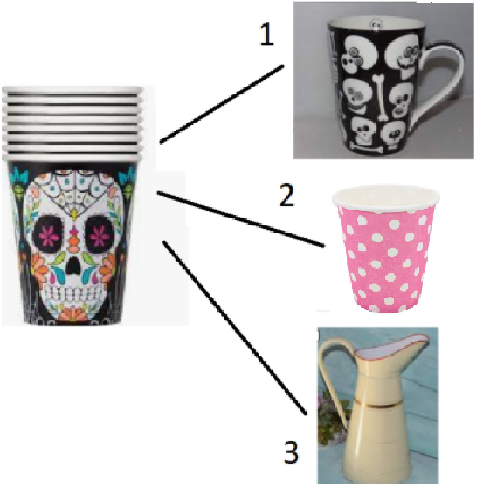

# Recommendation Function
Firstly it pulls the closest matching available name based on the input then orders the similarity dataframe by that game title.

In [ ]:
check_lists=['21980','22091','21790'] # New invoices
# Recommending the 3 closest products to the above products for which the stock code is given.
recommends = {check_id(df_germany, stock_no):
              check_id(df_germany, arl_recommender(rules_df=rules, product_id=stock_no, rec_count=3)) for stock_no in check_lists}
print(recommends)

In [ ]:
def game_recommendation(game):
    #Insert closest title here
    game, distance_score = find_closest_title(game)
    #Counter for Ranking
    number = 1
    print('Recommended because you played {}:\n'.format(game))
    
    for n in game_sim_df.sort_values(by = game, ascending = False).index[1:6]:
        print("#" + str(number) + ": " + n + ", " + str(round(game_sim_df[game][n]*100,2)) + "% " + "match")
        number +=1  

# Make Recommender Interactive with Gradio
What would recommenders be without users to recommend to?
With Gradio we can make the input more easier for anyone to use and even hypertune some of the parameters.
If you want to know more about the cool stuff you can do with Gradio, visit their website.

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
recommender_interface = gr.Interface(game_recommendation, ["text"], 
                           ["text"], title="Top 5 Game Recommendations", description="This is a Recommendation Engine based on how Metacritic professional reviewers have scored games up to 2019 (apologies for the out of date data). Simply input a game you have enjoyed playing and it should return 5 games that have been rated similarily")

recommender_interface.launch(debug=True)